# Linear Diffusive Hydrodynamics

\begin{align}
\partial_t \vec{u} - \nabla^2 \vec{u} + \nabla p &= 0 \\
\nabla \cdot \vec{u} &= 0 \\
\vec{u}(r=1) &= 0 \text{ (no slip) }
\end{align}


In [3]:
import dedalus_sphere.zernike as Zernike
from dedalus_sphere.spin_operators import xi

import numpy as np
import scipy as sp
import scipy.sparse as sparse
from scipy.special import spherical_jn
from scipy.linalg import eig
import matplotlib.pyplot as plt
%matplotlib notebook

np.set_printoptions(precision=3,suppress=True)

dim = 3
D = Zernike.operator(dim, 'D')
E = Zernike.operator(dim, 'E')
Id = Zernike.operator(dim, 'Id')

In [4]:
Nmax, alpha, ell = 256, 0, 50

In [5]:
def eigsort(A, B, cutoff=np.inf):
    vals, vecs = eig(A, b=B)
    bad = (np.abs(vals) > cutoff)
    vals[bad] = np.nan
    vecs = vecs[:,np.isfinite(vals)]
    vals = vals[np.isfinite(vals)]

    i = np.argsort(vals.real)
    vals, vecs = vals[i], vecs[:, i]

    return vals, vecs


### Analytic Solution

In [6]:
def dispersion_zeros(ell,n,a=0,guess=None,imax=20,nk=10,eps=0.1):
    j = spherical_jn
    def F(k,deriv=False): 
        return j(ell,k,derivative=deriv) - a*j(ell+2,k,derivative=deriv)
    
    if guess == None:    
        kmax = np.pi*(n+ell/2 + eps)
        k = np.linspace(0,kmax,int(kmax*nk))
        S = np.sign(F(k))
        i = np.where(np.abs(np.roll(S,-1)-S)==2)[0]
        k = 0.5*(k[i]+k[i+1])
    else: k = guess
    
    for i in range(imax):
        dk =  F(k)/F(k,deriv=True)
        k -= dk
    
    return k

def wavenumbers(ell,n):
    k = {} 
    k['toroidal'] = dispersion_zeros(ell,n)
    k['poloidal'] = dispersion_zeros(ell+1,n)
    return k
    
def eigenvalues(k,n):
    kk = np.sort(np.concatenate((k['toroidal'],k['poloidal'])))
    kk = kk[0:min(n,len(kk))]**2
    return kk

# Bessel equation, analytic eigenvalues
wavenumbers_analytic = wavenumbers(ell,Nmax)
evalues_analytic = eigenvalues(wavenumbers_analytic,2*Nmax)


### Tau Method

In [7]:
Z = 0*Id(Nmax, alpha, ell)

bc_minus = Zernike.polynomials(dim,Nmax,alpha,ell-1,1.0)
bc_0     = Zernike.polynomials(dim,Nmax,alpha,ell,  1.0)
bc_plus  = Zernike.polynomials(dim,Nmax,alpha,ell+1,1.0)

L00 = -(D(-1) @ D(+1))(Nmax, alpha, ell-1)
L11 = -(D(-1) @ D(+1))(Nmax, alpha, ell)
L22 = -(D(-1) @ D(+1))(Nmax, alpha, ell+1)
L03 = xi(-1,ell) * (E(+1) @ D(-1))(Nmax, alpha, ell)
L23 = xi(+1,ell) * (E(+1) @ D(+1))(Nmax, alpha, ell)
L30 = xi(-1,ell) * D(+1)(Nmax, alpha, ell-1)
L32 = xi(+1,ell) * D(-1)(Nmax, alpha, ell+1)

M00 = (E(+1) @ E(+1))(Nmax, alpha, ell-1)
M11 = (E(+1) @ E(+1))(Nmax, alpha, ell)
M22 = (E(+1) @ E(+1))(Nmax, alpha, ell+1)

# boundary conditions
L00 = sparse.vstack([L00, bc_minus])
L03[-1,:] = 0
L11 = sparse.vstack([L11, bc_0])
L22 = sparse.vstack([L22, bc_plus])
L23 = sparse.vstack([L23, np.zeros(Nmax)])
L30 = sparse.vstack([L30, np.zeros(Nmax)])

M00[-1,:] = 0
M11[-1,:] = 0
M22[-1,:] = 0

L = sparse.bmat([[L00,Z,Z,L03],[Z,L11,Z,Z],[Z,Z,L22,L23],[L30,Z,L32,Z]])
M = sparse.block_diag([M00,M11,M22,Z])

evalues_tau, evectors_tau = eigsort(L.todense(), M.todense())

/opt/miniconda3/envs/dedalus/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


### Galerkin Method

In [8]:
Z = 0*Id(Nmax, alpha, ell)

L00 = -(D(-1) @ D(+1) @ E(-1))(Nmax, alpha+1, ell-1)
L11 = -(D(-1) @ D(+1) @ E(-1))(Nmax, alpha+1, ell)
L22 = -(D(-1) @ D(+1) @ E(-1))(Nmax, alpha+1, ell+1)
L03 = xi(-1,ell) * (E(+1) @ D(-1))(Nmax, alpha, ell)
L23 = xi(+1,ell) * (E(+1) @ D(+1))(Nmax, alpha, ell)
L23 = sparse.vstack([L23, np.zeros(Nmax)])
L30 = xi(-1,ell) * (D(+1) @ E(-1))(Nmax, alpha+1, ell-1)
L32 = xi(+1,ell) * (D(-1) @ E(-1))(Nmax, alpha+1, ell+1)[:Nmax,:]

M00 = (E(+1) @ E(+1) @ E(-1))(Nmax, alpha+1, ell-1)[:Nmax,:]
M11 = (E(+1) @ E(+1) @ E(-1))(Nmax, alpha+1, ell)[:Nmax,:]
M22 = (E(+1) @ E(+1) @ E(-1))(Nmax, alpha+1, ell+1)[:Nmax,:]

L = sparse.bmat([[L00,Z,Z,L03],[Z,L11,Z,Z],[Z,Z,L22,L23],[L30,Z,L32,Z]])
M = sparse.block_diag([M00,M11,M22,Z])

evalues_galerkin, evectors_galerkin = eigsort(L.todense(), M.todense())

### Plot the Errors

<IPython.core.display.Javascript object>


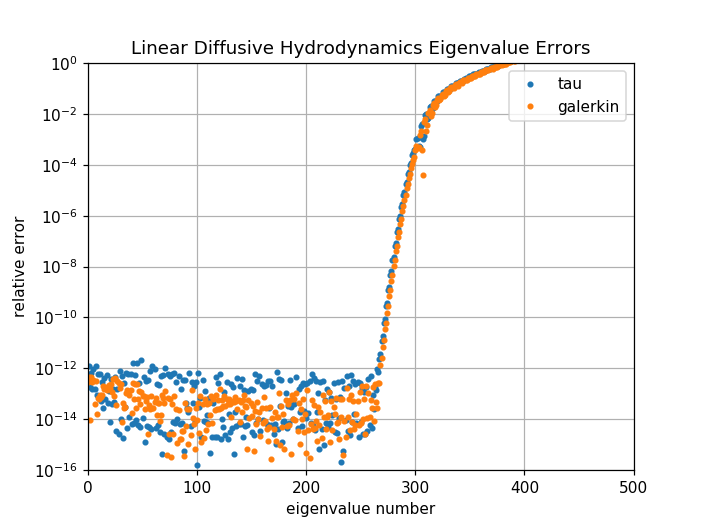

In [11]:
def error(vals):
    return np.abs(vals**2-evalues_analytic[:len(vals)]**2)/np.abs(evalues_analytic[:len(vals)]**2)

errors_tau = error(evalues_tau)
errors_galerkin = error(evalues_galerkin)

plt.figure()
plt.semilogy(errors_tau, '.', label='tau')
plt.semilogy(errors_galerkin, '.', label='galerkin')
plt.xlim([0,500])
plt.ylim([10**-16,10**0])
plt.legend()
plt.xlabel('eigenvalue number')
plt.ylabel('relative error')
plt.title('Linear Diffusive Hydrodynamics Eigenvalue Errors')
plt.grid()
